In [ ]:
!unzip drive/MyDrive/OceanChalenge/ocean_elements_v5.zip

unzip:  cannot find or open drive/MyDrive/OceanChalenge/ocean_elements_v5.zip, drive/MyDrive/OceanChalenge/ocean_elements_v5.zip.zip or drive/MyDrive/OceanChalenge/ocean_elements_v5.zip.ZIP.


In [ ]:
!unzip drive/MyDrive/OceanChalenge/masked_elements.zip

In [ ]:
!pip install tensorflow-addons

  Using cached tensorflow_addons-0.15.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)


In [ ]:
import os
import random
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [ ]:
strategy = tf.distribute.experimental.CentralStorageStrategy()

# Loading Dataset

# Datei hochladen






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ocean_v2 = 'ocean_elements'
ocean_labels = os.listdir(ocean_v2)
filenames = []
labels = []
for label in ocean_labels:
    files = [os.path.join(ocean_v2, label, filename)
                  for filename in os.listdir(os.path.join(ocean_v2, label))]
    filenames += files
    labels += [ocean_labels.index(label)] * len(files)
joined = list(zip(filenames, labels))
random.shuffle(joined)
filenames, labels = zip(*joined)
print(len(filenames), len(labels))

2481 2481


In [ ]:
masked_filenames = os.listdir('masked_images')
masked_filenames

['ef614184a4513889c5bac22ee51815e7.jpg',
 '8660e63af33c7cd96257bbd23b91cbbd.jpg',
 '3df3d7e1620831f0a84cfb248f811cda.jpg',
 '0901a6b281ae7725494c8605e6d2e4cc.jpg',
 '2d99e3e0cadb85d6169beca66a966b78.jpg',
 'f8c4d642e546ddaac1d9b531a06039a6.jpg',
 '0133c2f90e9842624a0918e0f6292f08.jpg',
 '1ad929641399ce12952b73a08d2f251f.jpg',
 'efdef69b02c6f0b4b1664d18622da00b.jpg']

In [ ]:
names = [filename.split('/')[-1] for filename in filenames]

In [ ]:
names.index('f8c4d642e546ddaac1d9b531a06039a6.jpg')

172

In [ ]:
#A dataset where every each image contains his own masked image
dataset_images = [
    (filenames[names.index(maskfile)], os.path.join('masked_images', maskfile)) 
    for maskfile in masked_filenames
]
dataset_images

[('ocean_elements/fauna/ef614184a4513889c5bac22ee51815e7.jpg',
  'masked_images/ef614184a4513889c5bac22ee51815e7.jpg'),
 ('ocean_elements/roca/8660e63af33c7cd96257bbd23b91cbbd.jpg',
  'masked_images/8660e63af33c7cd96257bbd23b91cbbd.jpg'),
 ('ocean_elements/basura/3df3d7e1620831f0a84cfb248f811cda.jpg',
  'masked_images/3df3d7e1620831f0a84cfb248f811cda.jpg'),
 ('ocean_elements/basura/0901a6b281ae7725494c8605e6d2e4cc.jpg',
  'masked_images/0901a6b281ae7725494c8605e6d2e4cc.jpg'),
 ('ocean_elements/basura/2d99e3e0cadb85d6169beca66a966b78.jpg',
  'masked_images/2d99e3e0cadb85d6169beca66a966b78.jpg'),
 ('ocean_elements/fauna/f8c4d642e546ddaac1d9b531a06039a6.jpg',
  'masked_images/f8c4d642e546ddaac1d9b531a06039a6.jpg'),
 ('ocean_elements/basura/0133c2f90e9842624a0918e0f6292f08.jpg',
  'masked_images/0133c2f90e9842624a0918e0f6292f08.jpg'),
 ('ocean_elements/basura/1ad929641399ce12952b73a08d2f251f.jpg',
  'masked_images/1ad929641399ce12952b73a08d2f251f.jpg'),
 ('ocean_elements/fauna/efdef69b02c6

In [ ]:
def load_image(filename):
    img = cv2.imread(filename)
    img = cv2.resize(img, (960, 540), 0, 0, interpolation = cv2.INTER_NEAREST)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.float32(img / 255)
    return img

In [ ]:
rot = tf.keras.layers.experimental.preprocessing.RandomRotation(np.pi*2)
def random_crop(input_image, target_image): 
    stacked_image = tf.stack([input_image, target_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image,
        size=[2, 256, 256, 3]
    )
    return cropped_image[0], cropped_image[1]

def random_rotation(input_image, target_image):
    concatenated_image = tf.concat([input_image, target_image], axis=2)
    rotated_image = rot(concatenated_image)
    # random_angles = np.random.random() * (2*np.pi)
    # rotated_image = tfa.image.rotate(
    #     stacked_image, 
    #     angles = (random_angles,) * 2, 
    #     interpolation= 'nearest')
    return rotated_image[:,:,:3], rotated_image[:,:,3:]


@tf.function()
def normalize(input_image, target_image):
    input_image = (input_image * 2) - 1
    target_image = (target_image * 2) - 1
    return input_image, target_image

@tf.function()
def random_jitter(input_image, target_image):
    # randomly cropping to 256 x 256 x 3
    # zufälliges Beschneiden auf 256 x 256 x 3
    input_image, target_image = random_crop(input_image, target_image)

    input_image = tf.image.random_brightness(input_image, 0.1)

    input_image = tf.image.random_contrast(input_image, 1, 1.2)

    input_image, target_image = random_rotation(input_image, target_image)

    if tf.random.uniform([1]) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)

    input_image, target_image = normalize(input_image, target_image)
    return input_image, target_image

In [ ]:
images = [(load_image(inp), load_image(tar)) for inp, tar in dataset_images]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


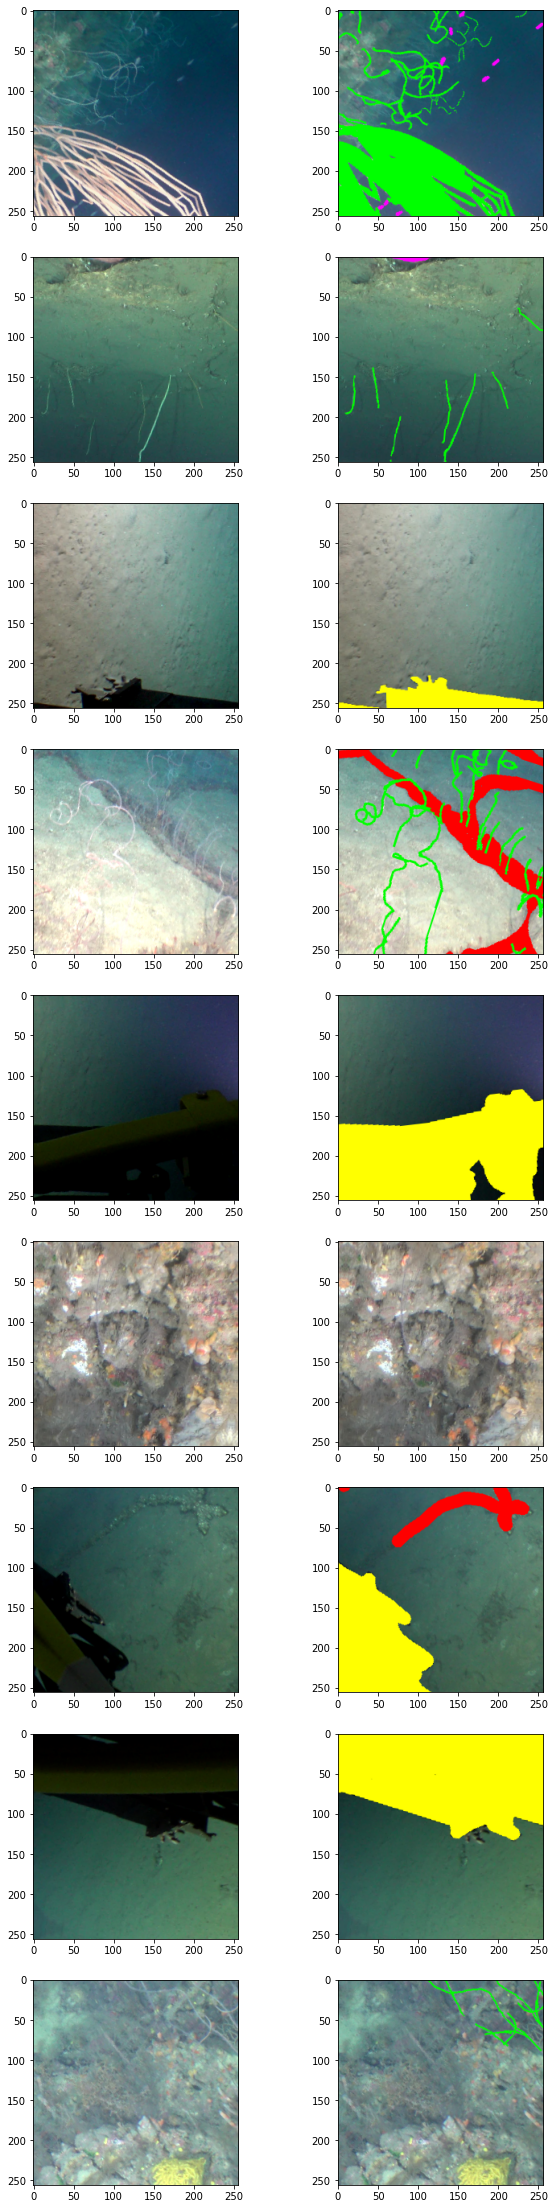

In [ ]:
plt.figure(figsize=(10, 40))
for i, (image, target) in enumerate(images):
    image, target = random_jitter(image, target)
    image = (image + 1) / 2
    target = (target + 1) / 2
    plt.subplot(9, 2, 2 * (i+1) -1)
    plt.imshow(image)
    plt.subplot(9, 2, 2 * (i+1))
    plt.imshow(target)
plt.show()

In [ ]:
images = tf.cast(images, tf.float32)
dataset = tf.data.Dataset.from_tensor_slices(
    (images[:,0], images[:,1])
).map(random_jitter).shuffle(400).repeat().batch(1)

In [ ]:
for inp, tar in dataset.repeat().take(10):
    print(inp.shape, tar.shape)

(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)


# Neural network, image segmentation


In [ ]:
initializer = tf.random_normal_initializer(0., 0.02)

def downsample(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(
        filters, size, strides=2, padding='same',
        kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(
        filters, size, strides=2,padding='same',
        kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [ ]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(2**4, 4, apply_batchnorm=False),
        downsample(2**5, 4),
        downsample(2**6, 4),
        downsample(2**7, 4),
        downsample(2**8, 4),
        downsample(2**8, 4),
        downsample(2**8, 4),
        downsample(2**8, 4),
    ]
    up_stack = [
        upsample(2**8, 4, apply_dropout=True),
        upsample(2**8, 4, apply_dropout=True),
        upsample(2**8, 4, apply_dropout=True),
        upsample(2**7, 4),
        upsample(2**6, 4),
        upsample(2**5, 4),
        upsample(2**4, 4),
    ]
    last = tf.keras.layers.Conv2DTranspose(
        3, 4, strides=2, padding='same',
        kernel_initializer=initializer, activation='tanh')  # (batch_size, 256, 256, 3)
    X = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        X = down(X)
        skips.append(X)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        X = up(X)
        X = tf.keras.layers.Concatenate()([X, skip])

    X = last(X)
    return tf.keras.Model(inputs=inputs, outputs=X)

In [ ]:
generator = Generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 16) 768         input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 32)   8320        sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 64)   33024       sequential_1[0][0]               
______________________________________________________________________________________________

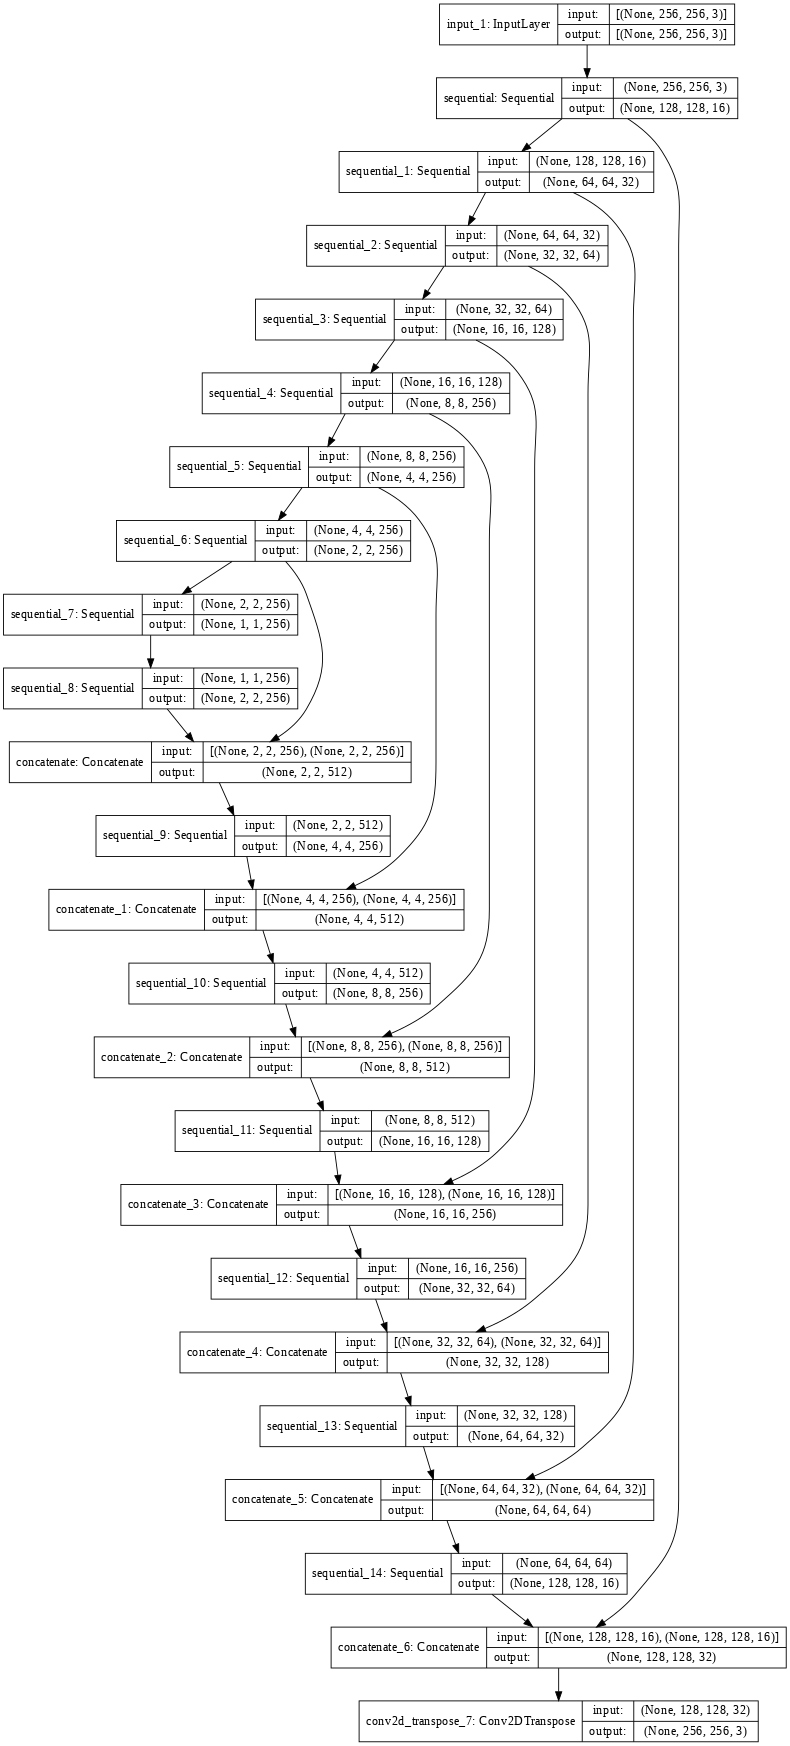

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
def Discriminator():
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(2**4, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(2**5, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(2**6, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1,kernel_initializer=initializer,
        use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
        1, 4, strides=1,kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = Discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 128, 128, 16) 1536        concatenate_7[0][0]        

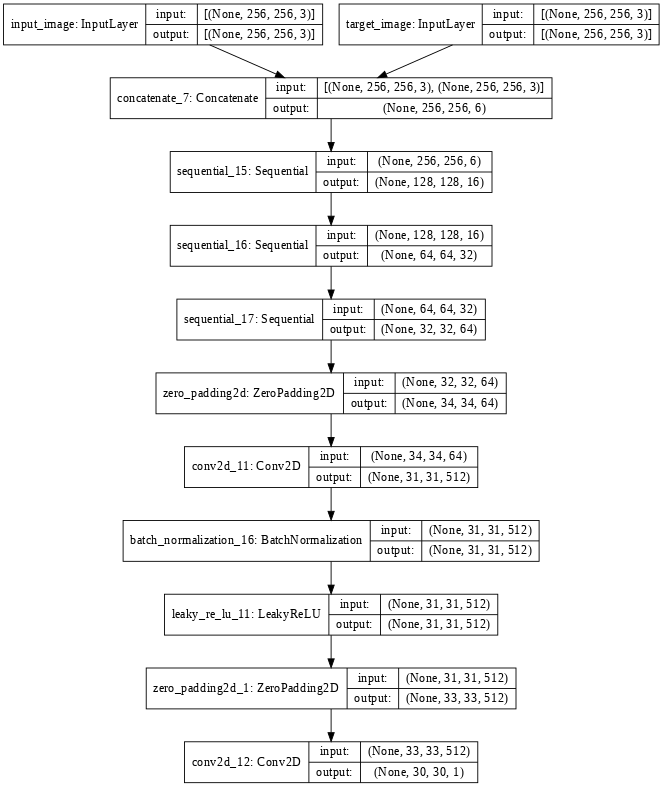

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
import time

time: 0.03965


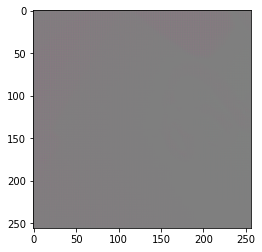

In [ ]:
start = time.time()
gen_output = generator(inp, training=False)
print(f'time: %.5f' % (time.time() - start))
plt.imshow((gen_output[0] + 1) / 2)
plt.show()

time: 0.01461


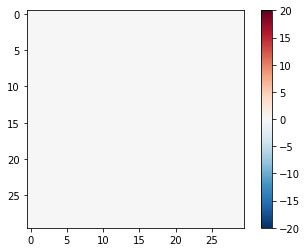

In [ ]:
start = time.time()
dis_output = discriminator([inp, tar], training=False)
print(f'time: %.5f' % (time.time() - start))
plt.imshow(dis_output[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
with strategy.scope():
    generator = Generator()#Compile the model
    discriminator = Discriminator()
    generator_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)
    loss_object = tf.keras.losses.BinaryCrossentropy(
        from_logits=True,
        reduction=tf.keras.losses.Reduction.NONE)
    loss_metric_gen = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
    loss_metric_dis = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
    acc_metric = tf.keras.metrics.CosineSimilarity()

    def generator_loss(disc_generated_output, gen_output, target):
        gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
        # Mean absolute error
        l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
        total_gen_loss = gan_loss + (100 * l1_loss)h
        return total_gen_loss, gan_loss, l1_loss

    def discriminator_loss(disc_real_output, disc_generated_output):
        real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
        generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_prefix, max_to_keep=10)

In [ ]:
manager.restore_or_initialize()

'./training_checkpoints/ckpt/ckpt-105'

In [ ]:
import pandas as pd

In [ ]:
if os.path.exists('history.csv'):
    history = pd.read_csv('history.csv')
else:
    history = pd.DataFrame()
history

acc  disc_loss   gen_loss
0    0.765400   1.379000  22.041000
1    0.798591   1.136637  19.539724
2    0.803290   1.136236  19.123211
3    0.805077   1.118621  18.805408
4    0.807214   1.104889  18.636305
..        ...        ...        ...
96   0.878295   0.817842  13.966485
97   0.878644   0.815921  13.946651
98   0.879041   0.812763  13.928741
99   0.879433   0.810929  13.908150
100  0.879739   0.808925  13.892026

[101 rows x 3 columns]

In [ ]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(
        gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients, discriminator.trainable_variables))
    
    loss_metric_gen.update_state(gen_total_loss * strategy.num_replicas_in_sync)
    loss_metric_dis.update_state(disc_loss * strategy.num_replicas_in_sync)
    acc_metric.update_state(target, gen_output)

    #with summary_writer.as_default():
    #    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    #    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    #    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    #    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, test_ds, steps):
    global history
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    # example_input, example_target = next(iter(test_ds.take(1)))
    start_fit = time.time()
    train_ds = train_ds.repeat().take(steps).enumerate()
    for step, (input_image, target) in train_ds:
        # generate_images(generator, example_input, example_target)
        start = time.time()
        strategy.run(train_step, args=(input_image, target, step))
        gen_loss = loss_metric_gen.result()
        disc_loss = loss_metric_dis.result()
        acc = acc_metric.result()
        print("\rStep: %5d/%d gen_loss: %.3f disc_loss: %.3f acc: %.4f" 
              % (step+1, steps, gen_loss, disc_loss, acc), end="")

        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 1000 == 0:
            save_path = manager.save()
            history = history.append({
                'gen_loss':float(gen_loss), 
                'disc_loss':float(disc_loss), 
                'acc': float(acc)}, ignore_index=True)
            history.to_csv('history.csv', index=False)
            print(f'\nPunto de control almacenado en {save_path}')
            loss_metric_gen.reset_states()
            loss_metric_dis.reset_states()
    acc = acc_metric.result()
    gen_loss = loss_metric_gen.result()
    print(f'\nTrain result | acc: {acc}',
              f'| gen_loss: {gen_loss}',
              f'| time: {round(time.time()-start_fit, 4)}')


In [ ]:
fit(dataset, None, steps=1000)

INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Red

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


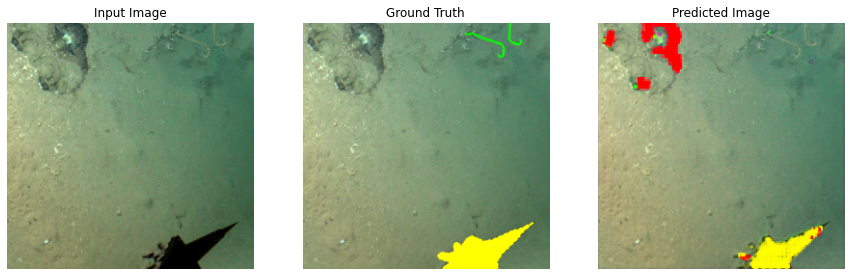

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


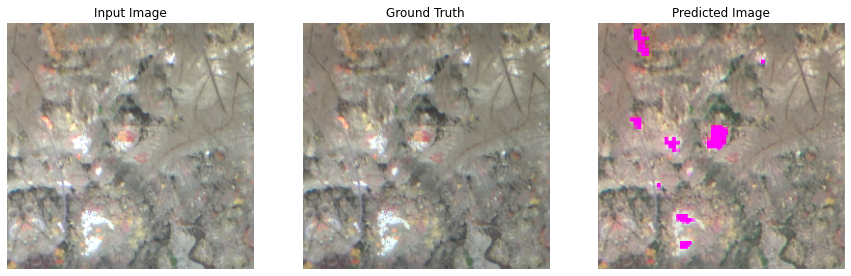

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


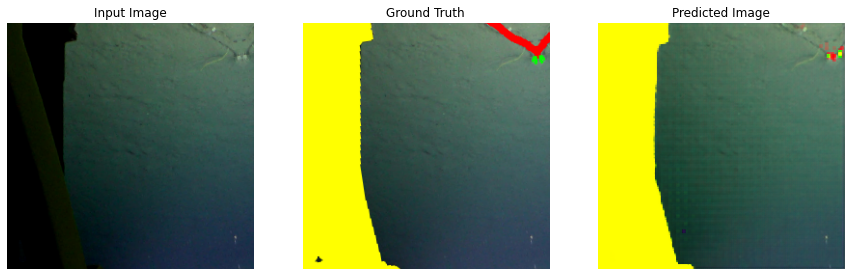

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


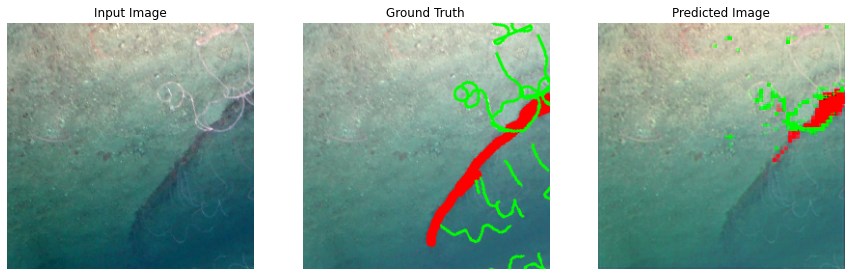

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


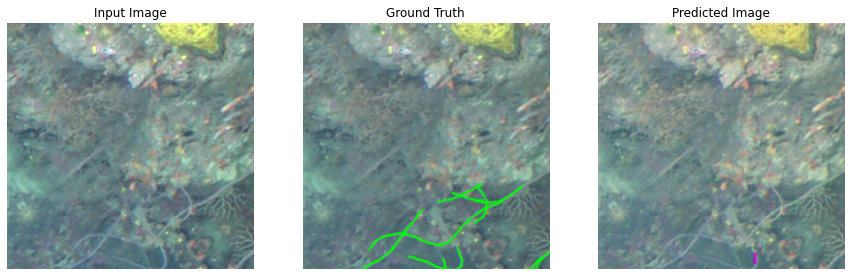

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


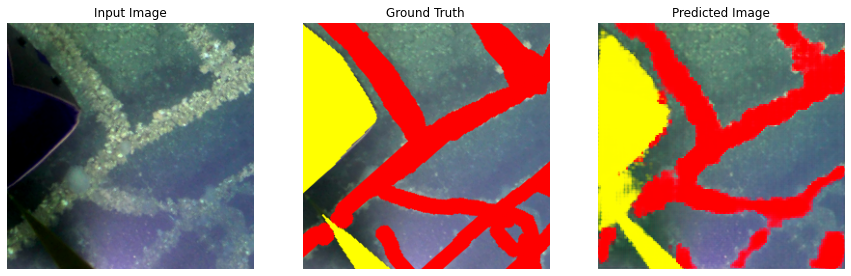

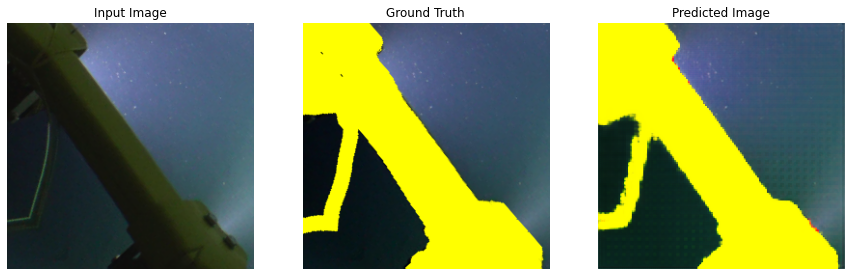

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


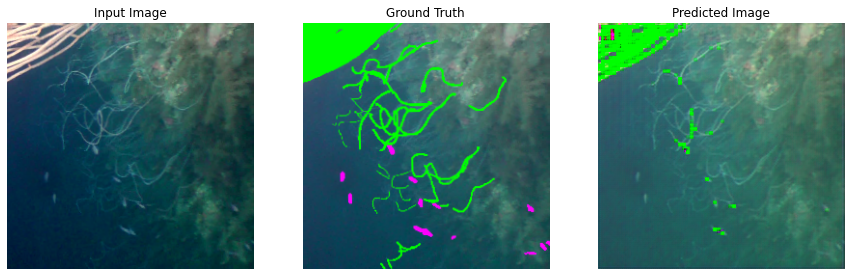

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


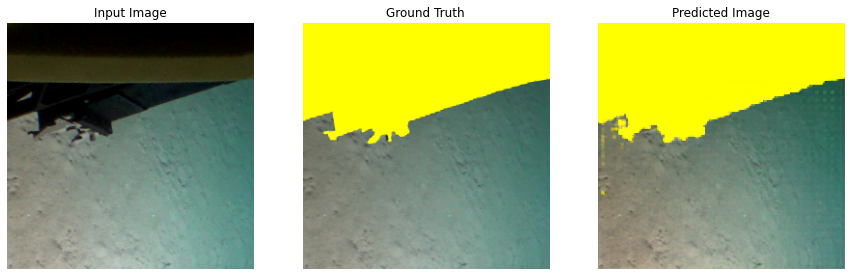

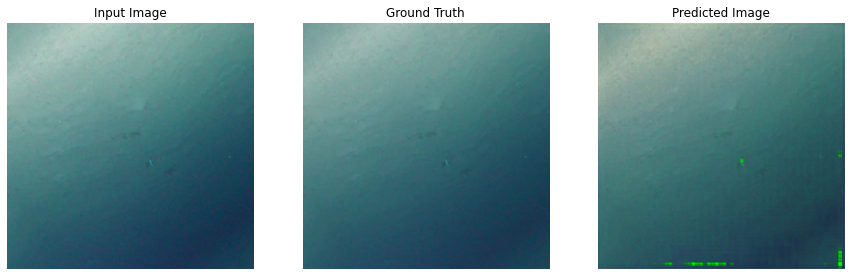

In [ ]:
for example_input, example_target in dataset.take(10):
    generate_images(generator, example_input, example_target)

In [ ]:
!zip -r checkpoints.zip training_checkpoints

	zip warning: name not matched: training_checkpoints

zip error: Nothing to do! (try: zip -r checkpoints.zip . -i training_checkpoints)


In [ ]:
!unzip checkpoints.zip

unzip:  cannot find or open checkpoints.zip, checkpoints.zip.zip or checkpoints.zip.ZIP.


In [ ]:
!rm -r training_checkpoints

In [ ]:
!rm -r ocean_elements